# Contrastive Learning

This example demonstrates how to implement a Contrastive Learning Siamese Network using Contrastive Loss to determine whether a pair of images are similar. Contrastive Loss was introduced by Yann Le Cunn et al. in the paper ["Dimensionality Reduction by Learning an Invariant Mapping."](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf).


In [25]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

Let's start by loading the dataset:


In [26]:
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


Let's now display some of the images with their labels:


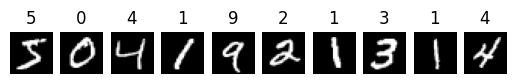

In [27]:
import matplotlib.pyplot as plt


for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")

We want to create a neural network that receives every pixel as an input. Let's reshape the data to have a single array with `28 x 28 = 784` pixels.


In [30]:
X_train.shape[2]

28

In [31]:
X_train = X_train.reshape(-1, 784)
print("X_train shape:", X_train.shape)

X_train shape: (60000, 784)


We need to do the same with the test data:


In [32]:
X_test = X_test.reshape(-1, 784)
print("X_test shape:", X_test.shape)

X_test shape: (10000, 784)


In [35]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

We now want to normalize the pixel values to a range between 0 and 1 (instead of 0 to 255). We can use the min-max normalization formula for this:

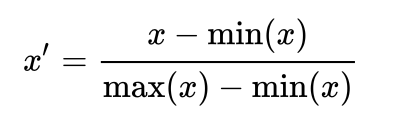

Here is what the code to implement this formula would look like:

```
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
```

For an image, `X_train.min()` is `0` and `X_train.max()` is `255`, so we can simplify the formula to:

```
X_train = X_train / 255.0
```


In [36]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [37]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

We'll train a Siamese Network using positive and negative pairs of images. A positive pair consists of two images representing the same digit, while a negative pair consists of two images representing different digits.


In [38]:
import numpy as np


def generate_pairs(X, y):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        label = y[i]

        # Find a random image representing the same digit.
        # This is a positive pair.
        j = np.random.choice(np.where(y == label)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[j]])

        # Since this is a positive pair, the ground truth label is 0.
        # The distance between images representing the same digit should be small,
        # and that's why we use 0 as the label.
        y_pairs.append([0])

        # Find a random image representing a different digit.
        # This is a negative pair.
        k = np.random.choice(np.where(y != label)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[k]])

        # Since this is a negative pair, the ground truth label is 1.
        # The distance between images representing different digits should be large,
        # and that's why we use 1 as the label.
        y_pairs.append([1])

    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

Let's generate the pairs for training and testing the model:


In [39]:
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs shape:", X_train_pairs.shape)
print("y_train_pairs shape:", y_train_pairs.shape)

print("X_test_pairs shape:", X_test_pairs.shape)
print("y_test_pairs shape:", y_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
y_train_pairs shape: (120000, 1)
X_test_pairs shape: (20000, 2, 784)
y_test_pairs shape: (20000, 1)


Let's display some of these pairs to ensure they were generated correctly:


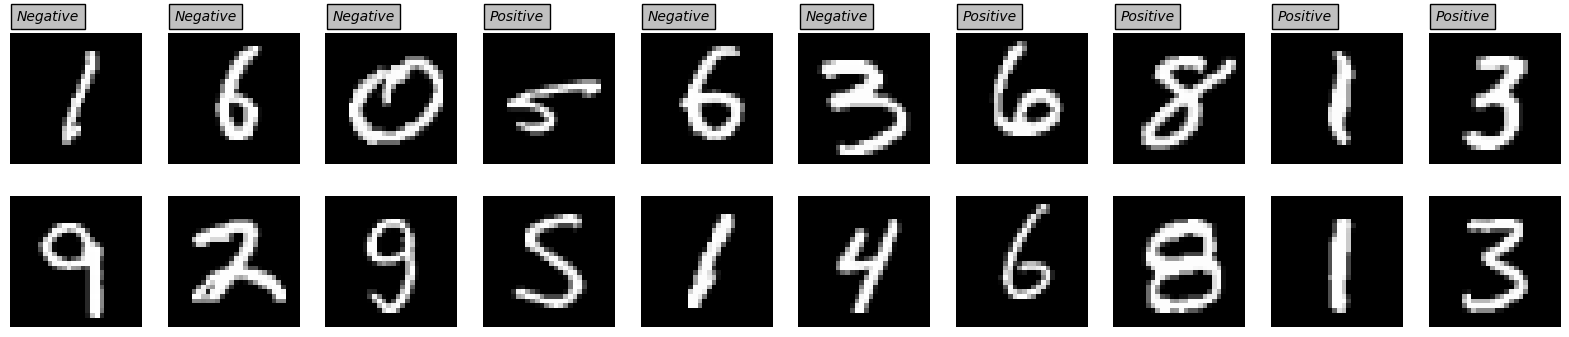

In [40]:
def display_pairs(X, y, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - X: An array containing the image pairs.
        - y: An array containing the corresponding label (0 if both
            pairs are the same, and 1 if both pairs are different.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()


display_pairs(X_train_pairs, y_train_pairs)

Let's create a function to build a simple, fully-connected neural network. This network will be responsible of generating the embeddings for the images:


In [13]:
from keras import Input
from keras.layers import Dense
from keras.models import Sequential


def build_network():
    model = Sequential(
        [
            Input(shape=(784,)),
            Dense(512, activation="relu"),
            Dense(256, activation="relu"),
            Dense(128, activation=None),
        ]
    )

    return model

The Siamese Network will receive a pair of images as input:


In [14]:
input1 = Input(shape=(784,))
input2 = Input(shape=(784,))

Our network will have two branches, each one responsible for processing one of the images in the pair. We want to share the same weights between the branches, so we'll use the same network instance:


In [15]:
network = build_network()

twin1 = network(input1)
twin2 = network(input2)

2024-05-21 09:53:07.404451: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-05-21 09:53:07.404468: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-05-21 09:53:07.404475: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-05-21 09:53:07.404508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-21 09:53:07.404517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The output of the Siamese Network will be the distance between the embeddings of the two images. To do this, we can use a Lambda layer to calculate the Euclidean distance between the embeddings:


In [16]:
from keras.layers import Lambda
from keras.ops import norm


def euclidean_distance(twins):
    """Compute the euclidean distance (norm) of the output of
    the twin networks.
    """
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis=1, keepdims=True)


distance = Lambda(euclidean_distance)([twin1, twin2])

Let's now set up the model:


In [17]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

We'll use the Contrastive Loss to train the model. You can find the formula of this loss in the paper ["Dimensionality Reduction by Learning an Invariant Mapping."](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)


In [41]:
from keras.ops import cast, maximum, square


def contrastive_loss(y_true, y_pred):
    """
    Compute the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping."
    """

    margin = 1
    y_true = cast(y_true, y_pred.dtype)

    loss = (1 - y_true) / 2 * square(y_pred) + y_true / 2 * square(
        maximum(0.0, margin - y_pred)
    )

    return loss

Let's compile the model using the Contrastive Loss:

In [19]:
from keras.metrics import binary_accuracy

model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

Here is what the model architecture looks like:

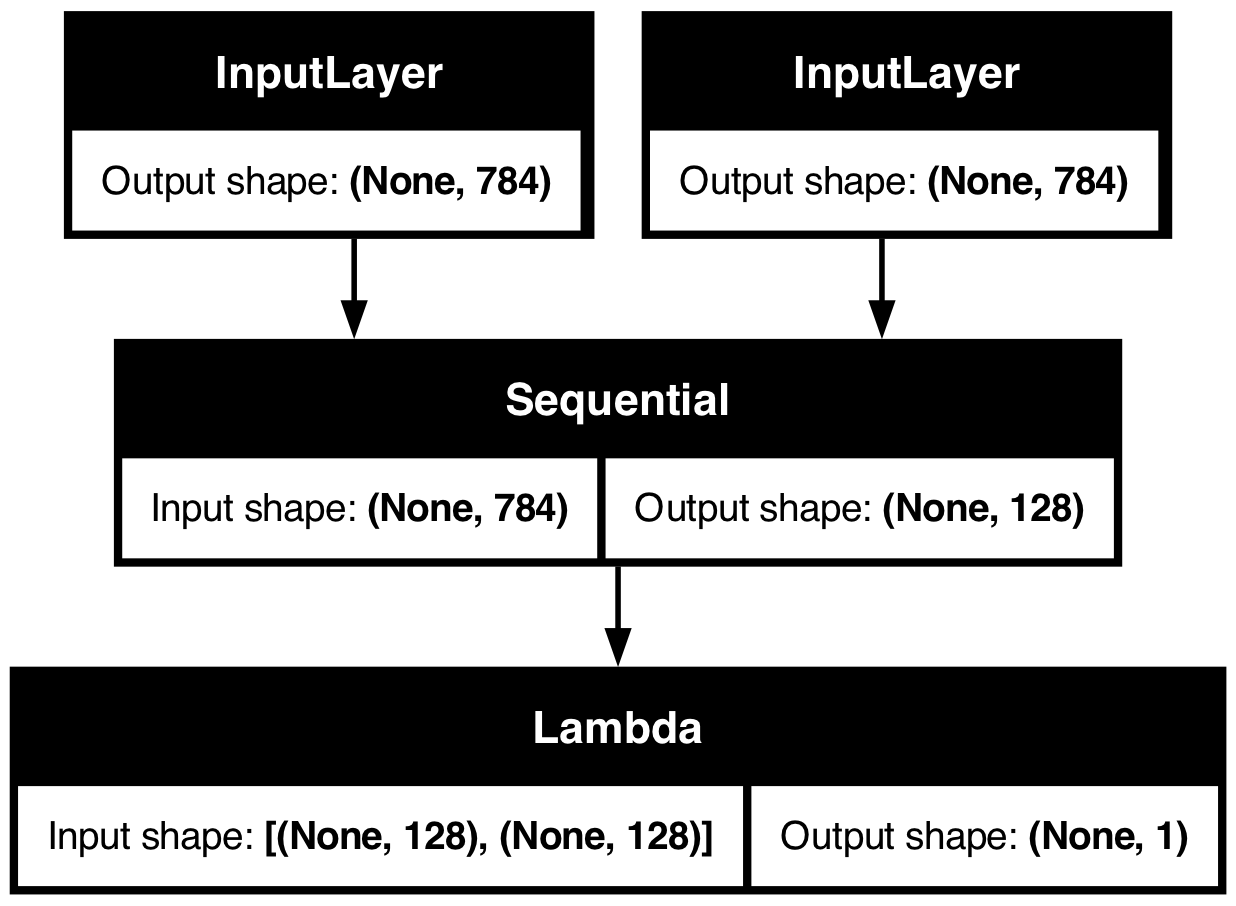

In [42]:
keras.utils.plot_model(
    model, to_file="model.png", show_shapes=True, show_layer_names=False
)

Let's fit the model:

In [43]:
history = model.fit(
    x=[X_train_pairs[:, 0], X_train_pairs[:, 1]],
    y=y_train_pairs[:],
    validation_data=([X_test_pairs[:, 0], X_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32,
    epochs=5,
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - binary_accuracy: 0.9902 - loss: 0.0074 - val_binary_accuracy: 0.9700 - val_loss: 0.0146
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - binary_accuracy: 0.9937 - loss: 0.0055 - val_binary_accuracy: 0.9705 - val_loss: 0.0147
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - binary_accuracy: 0.9945 - loss: 0.0048 - val_binary_accuracy: 0.9692 - val_loss: 0.0143
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - binary_accuracy: 0.9960 - loss: 0.0040 - val_binary_accuracy: 0.9717 - val_loss: 0.0138
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - binary_accuracy: 0.9964 - loss: 0.0035 - val_binary_accuracy: 0.9683 - val_loss: 0.0145


We can plot the train and validation loss during training:

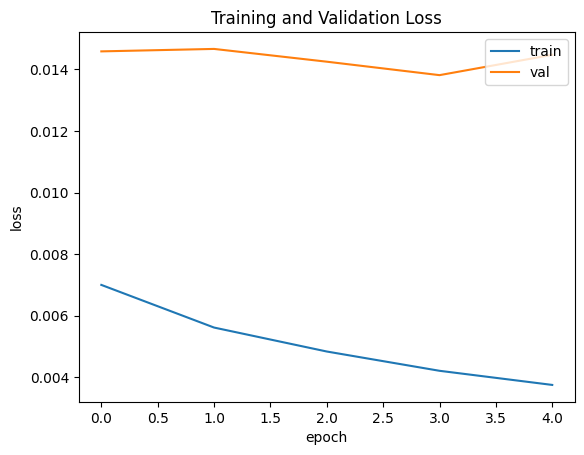

In [44]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

Let's evaluate the model using the test data and display some of the predictions:

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


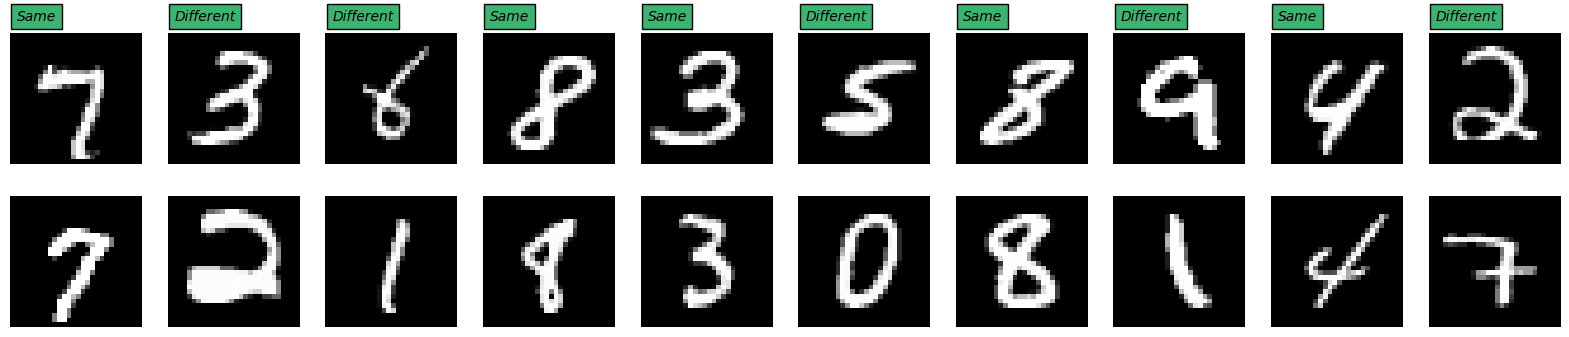

In [45]:
predictions = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]]) >= 0.5
display_pairs(X_test_pairs, predictions, predictions == y_test_pairs)

Finally, we can compute the accuracy of the model on the test data:

In [46]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.97
